## CS598APK Project - Structure with randomness - SVD

In [500]:
import numpy as np
import scipy.linalg as la
import numpy.linalg as nla
import fbpca
import sklearn.decomposition.pca as skpca
import matplotlib.pyplot as pt
%matplotlib inline
%aimport randomized_svd
%autoreload 1
import randomized_svd
from sklearn.utils import extmath
from sklearn.decomposition import randomized_svd as sklearn_svd
import time

## 1. Adaptive Range Finder

First obtain a low rank (k=20) matrix by computing the SVD of a random matrix and zeroing out singular values.

In [446]:
def low_rank_matrix_20(n=500):
    A = np.random.randn(n, n)
    U, s, Vh = la.svd(A)
    s[20:] = 0 
    return (U*s).dot(Vh)

Then check the rank using NumPy's matrix_rank.

In [488]:
A = low_rank_matrix_20()
print("A.shape: ", A.shape)
print("Rank: ", nla.matrix_rank(A))

A.shape:  (500, 500)
Rank:  20


Let's also implement a simple baseline that uses rank-revealing QR. It runs in $O(n^3)$.

In [466]:
def rank_revealing_QR(A):
    Q, R, _ = la.qr(A, pivoting=True)
    Rd = np.diag(R)
    tol = 1e-10
    return Q[:,:sum(np.abs(np.diag(R)) > tol)]

Using the method of Halko et al., we compute a low rank approximation of A by finding the orthogonal basis $Q$ of $Y = A\Omega$ where $\Omega$ is an m by k matrix with numbers randomly drawn from gaussian distribution, and $Q$ such that $QR=Y$. k is an estimate of A's rank. The "adaptive" part of adaptive range finding is for computing $Q$ when we don't know $k$ beforehand, we can start with an initial estimate and incrementally add random columns to $\Omega$ until $(I-QQ^T)A$ is small enough.

### Incremental orthogonalization

For incrementally orthogonalizing $Q$, we have two implementations:

#### Modified Gram Schmidt:

This is an implementation of Gram Schmidt that allows us to assume that the first $k$ columns are already orthogonal and only adjust columns $k+1,...,m$. While this makes sense, it is slow in practice because the columns are processed one by one (for the numerically stable version of Gram Schmidt) in Python and doesn't take advantage of low level vectorization. Given an n by k+m matrix Q,

1. let $i=k$.
2. project $i$th column to the $j=1$th column, subtract the projection, and update $Q_{i}$. repeat for all columns until $j=i-1$.
3. normalize the resulting $i$th columnr and re-project it to the orthogonal complement of Q for floating point stability. If this step is an over estimation, column $i$ can end up having a near-zero length vector which may not be orthogonal after normalizing.
4. let $i=i+1$ and repeat 2.
5. terminate after processing all $i=k,...,k+m$ columns.

The code can be found in gram_schmidt(S, start_col=0) in randomized_svd.py.


#### QR merging. Computing QR directly in the orthogonal complement projection of Q.

This method allows us to batch orthogonalize incrementally, taking advantage of low level QR factorization routines through SciPy by computing the basis of $A\Omega$ in the orthogonal complement projection of Q. Then we can simply _merge_ the two $Q$s by matrix concatenation to obtain the new basis.

QR merging is probably not the best name for this, but the temporary name got stuck and I ended up having to call it QR merging.

We want to add $p$ more columns to existing $Q$. Given $\Omega \in \mathbb{R}^{n \times p}, Q$ and $Y=A\Omega$,

1. Compute $\hat Y = (I-QQ^T)Y$. This step projects Y to the null space of Q. Columns of $\hat Y$ will be orthogonal to $Q$, but not orthogonal themselves which we take care of by computing QR. Using Matrix product associability, $(I-QQ^T)Y$ is more efficiently computed as
$Y-Q(Q^TY)$.

2. Compute $\hat Q, \hat R$ of $\hat Y$. Now the columns of $\hat Q$ are orthogonal, and either orthogonal to $Q$ (since $\hat Y$ was a null space projection) or parallel to a column in $Q$ which happens when $\hat Y$ was not full rank i.e. appending $\hat Q$ to $Q$ would be an overestimation of $A$'s range.

3. Check if $\hat Y$ is full rank by looking at the diagonal values of $\hat R$ i.e. if abs(diag(R)) has a very small value. If it is, the incremental orthogonalization is complete. Concatenate $\hat Q$ to $Q=[Q \hspace{2.5mm}\hat Q]$. If not, remove those columns from $\hat Q$ and then concatenate.

### Running time analysis
Now let's check the running times, in the order of, rank revealing QR (baseline), modified gram schmidt, and QR merging, with A.shape=(500,500), starting with 5 columns and incrementally adding 5.

In [498]:
expected_rank = 20
%timeit -r 5 -n 5    Q = rank_revealing_QR(A); assert Q.shape[1]==expected_rank
%timeit -r 5 -n 5    Q = randomized_svd.adaptive_range(A, k=5, p=5, method='modified_gram_schmidt'); assert Q.shape[1]==expected_rank
%timeit -r 5 -n 5    Q = randomized_svd.adaptive_range(A, k=5, p=5, method='qr_merging'); assert Q.shape[1]==expected_rank

5 loops, best of 5: 23.5 ms per loop
5 loops, best of 5: 5.71 ms per loop
5 loops, best of 5: 3.9 ms per loop


As one might expect, the $O(n^3)$ baseline takes the longest time, and the two methods implemented for this project are close to each other, although the naive Python implementation of gram schmidt is slower than the one that takes advantage of low level QR routines.

To show that the Python implementation of modified Gram Schmidt doesn't scale, let's try with a larger matrix, this time starting with 50 columns and adding 50 more in each iteration:

In [484]:
A = np.random.randn(2000,500).dot(np.random.randn(500,2000))
expected_rank = 500
%timeit -r 5 -n 5    Q = rank_revealing_QR(A); assert Q.shape[1]==expected_rank
%timeit -r 5 -n 5    Q = randomized_svd.adaptive_range(A, k=50, p=50, method='modified_gram_schmidt'); assert Q.shape[1]==expected_rank
%timeit -r 5 -n 5    Q = randomized_svd.adaptive_range(A, k=50, p=50, method='qr_merging'); assert Q.shape[1]==expected_rank

5 loops, best of 5: 1.15 s per loop
5 loops, best of 5: 4.4 s per loop
5 loops, best of 5: 318 ms per loop


Now let's see how long the adaptive randomzied range finder takes to compute the range of A with different ranks. We generate fixed-size (1500,1500) random matrice with different ranks. Then we assume we don't know the rank and estimate the range. The Python implementation of modified gram schmidt is excluded because it took too long to compute. We only use the "QR merging" method and compare it with our baseline RRQR which shouldn't be affected by the rank.

In [574]:
def rank_revealing_QR_time(k):
    A = np.random.randn(1500,k).dot(np.random.randn(k,1500)); start = time.time(); rank_revealing_QR(A); return time.time() - start
def adaptive_range_finder_time(k):
    A = np.random.randn(1500,k).dot(np.random.randn(k,1500)); start = time.time(); randomized_svd.adaptive_range(A, k=50, p=50); return time.time() - start
runner1 = lambda rank: sum([rank_revealing_QR_time(rank) for _ in range(5)])/5.0; runner2 = lambda rank: max([adaptive_range_finder_time(rank) for _ in range(3)]); ranks = range(50, 1300, 250); rrqr_times, adaptive_range_times = [], []
for rank in ranks:
    rrqr_times.append(runner1(rank)); adaptive_range_times.append(runner2(rank))

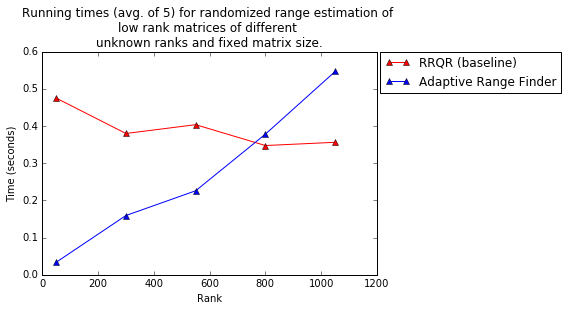

In [586]:
pt.plot(ranks, rrqr_times, 'y-^', label="RRQR (baseline)", color='r'); pt.plot(ranks, adaptive_range_times, 'm-^', label="Adaptive Range Finder", color='b')
pt.xlabel("Rank"); pt.ylabel("Time (seconds)"); pt.legend(loc=2, borderaxespad=0, bbox_to_anchor=(1.01, 1))
pt.title("Running times (avg. of 5) for randomized range estimation of \nlow rank matrices of different \nunknown ranks and fixed matrix size."); pt.show()

RRQR's running time is not affected by the rank, since the size of $A$ is constant.

The adaptive range finder's running time increases linearly as the (unknown) rank of $A$ increases. It starts with k=50 columns and adds p=50 in each iteration. And as $A$ reaches full rank, it runs slower than RRQR because of the overhead in the rank estimation procedure, as expected.

#### A-posteriori error  and stabilizing the orthogonal complement QR in batch orthogonalization

In each iteration, the adaptive range finder computes a-posteriori error $\left|E\right|_2$, $E=(I-QQ^T)A$ using $\left|E \omega\right|_2$. We could do power iterations in the error estimate, but adding the $O(N^3)$ operation every iteration is almost as expensive as computing a full 2-norm.

Let's check how the error threshold used as a termination criterion affects the number of orthogonal columns extracted. Here we make a low rank matrix with exponentially decreasing singular values, so that they decrease continuously.

In [3721]:
U, s, Vh = la.svd(np.random.randn(1200,1200))
A = (U*np.exp(-np.arange(1200)/10)).dot(Vh)
print("A.shape: ", A.shape, "rank:",  nla.matrix_rank(A))

A.shape:  (1200, 1200) rank: 290


In [3722]:
def num_columns(A, eps, method, stabilize=False):
    t = time.time(); Q = randomized_svd.adaptive_range(A, eps, k=10, p=10, method=method, power_iter_k=0, stabilize_qr_merging=stabilize)
    return Q.shape[1], time.time() - t

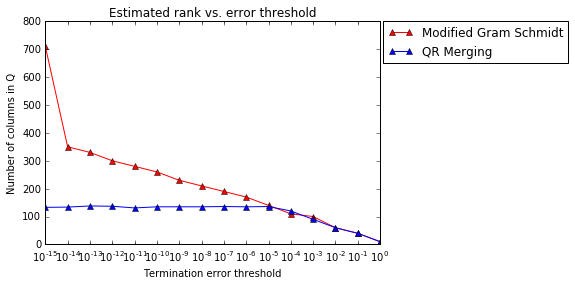

In [3723]:
num1 = [num_columns(A, pow(10,-i), 'modified_gram_schmidt')[0] for i in range(16)];  num2 = [num_columns(A, pow(10,-i), 'qr_merging', False)[0] for i in range(16)]; tols = [pow(10,-i) for i in range(16)];
pt.semilogx(tols, num1, 'y-^', label="Modified Gram Schmidt", color='r'); pt.semilogx(tols, num2, 'm-^', label="QR Merging", color='b') ;pt.xlabel("Termination error threshold"); pt.ylabel("Number of columns in Q")
pt.legend(loc=2, borderaxespad=0, bbox_to_anchor=(1.01, 1)); pt.title("Estimated rank vs. error threshold"); pt.show()

Due to numerical errors in the QR merging method, it turns out it cannot detect dimensions that correspond to low singular values, regardless of how small the threshold is (it terminates when it is not able to add any new columns that are orthogonal to existing columns in Q). Using ideas from how the modified gram schmidt was able to stabilize its orthogonal columns by re-projecting to the orthogonal complement, we compute an additional round of $QR=(I-QQ^T)Q_{prev}$.

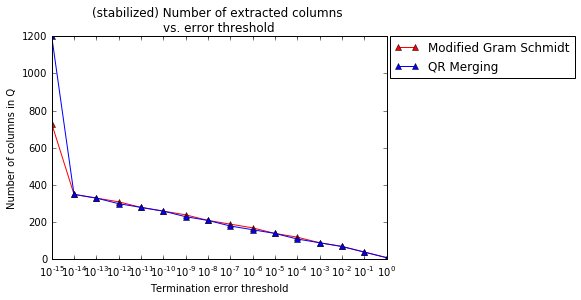

In [3151]:
num1 = [num_columns(A, pow(10,-i), 'modified_gram_schmidt')[0] for i in range(16)];  num2 = [num_columns(A, pow(10,-i), 'qr_merging', True)[0] for i in range(16)] ; tols = [pow(10,-i) for i in range(16)];
pt.semilogx(tols, num1, 'y-^', label="Modified Gram Schmidt", color='r'); pt.semilogx(tols, num2, 'm-^', label="QR Merging", color='b') ;pt.xlabel("Termination error threshold"); pt.ylabel("Number of columns in Q")
pt.legend(loc=2, borderaxespad=0, bbox_to_anchor=(1.01, 1)); pt.title("(stabilized) Number of extracted columns \nvs. error threshold"); pt.show()

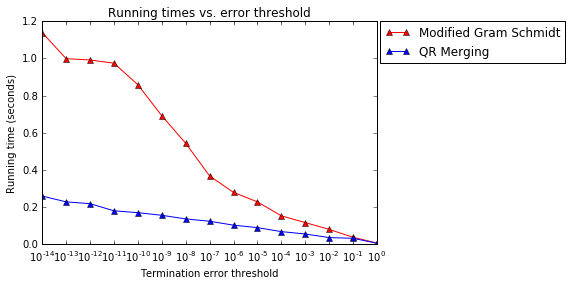

In [3152]:
num1 = [num_columns(A, pow(10,-i), 'modified_gram_schmidt')[1] for i in range(15)]; num2 = [num_columns(A, pow(10,-i), 'qr_merging', True)[1] for i in range(15)] ; tols = [pow(10,-i) for i in range(15)];
pt.semilogx(tols, num1, 'y-^', label="Modified Gram Schmidt", color='r'); pt.semilogx(tols, num2, 'm-^', label="QR Merging", color='b') ;pt.xlabel("Termination error threshold"); pt.ylabel("Running time (seconds)")
pt.legend(loc=2, borderaxespad=0, bbox_to_anchor=(1.01, 1)); pt.title("Running times vs. error threshold"); pt.show()

Now we can see that the "QR merging" method is stabilized, and it is now sensitive enough to low error threshold i.e. handles bases with very small singular values. And the "QR merging" method (the one that incrementally batch orthogonalizes new columns by computing QR in the orthogomal complement space and concatenating the resulting Q) is still significantly faster computationally (probably faster with a larger $p$).

#### Threshold detection

What if we don't know the threshold? If $\epsilon$ is not given (set to None), our implementation uses another termination criterion: when the error reaches a plateau. It stores $\left|E \omega\right|_2$ values of previous 8 iterations, and if the standard deviation of the second half is significantly smaller than the first half's, a convergence is detected and the iteration stops after discarding the columns added after the drop. This seems to work well; in the non-plateau rounds, the decrease in the error after each iteration is usually big enough to not be influenced by the 2-norm approximation error.

Let's check how well it turned out. We continue using the a low rank matrix with continuously decreasing singular values from the previous section.

In [3353]:
Q = randomized_svd.adaptive_range(A, None, k=10, p=50, method='modified_gram_schmidt', power_iter_k=0)
print("Error: ", la.norm(A-Q.dot(Q.T.dot(A)), 2), " Detected rank: ", Q.shape)

Error:  7.86038066753e-13  Detected rank:  (500, 260)


In [3354]:
Q = randomized_svd.adaptive_range(A, None, k=10, p=50, method='qr_merging', power_iter_k=0)
print("Error: ", la.norm(A-Q.dot(Q.T.dot(A)), 2), " Detected rank: ", Q.shape)

Error:  1.08085755557e-12  Detected rank:  (500, 260)


We can see that it picked a threshold around $\approx 10^{-9}$

In [3355]:
Q = rank_revealing_QR(A)
print("RRQR", " Error", la.norm(A-Q.dot(Q.T.dot(A)), 2), "Q.shape:", Q.shape)

RRQR  Error 2.77125827057e-12 Q.shape: (500, 150)


And it is pretty close to the $O(N^3)$ baseline: rank revealing QR + numpy's matrix_rank.

We observe that they slightly underestimate the range compared to RRQR, but it is reasonable considering that the singular values of $A$ decrease continuously and there isn't a single obvious cutoff.

#### Power iterations

Power iterations, i.e. $(AA^T)^qA\Omega$, seem to help in the initial estimate of $Q \in \mathbb{R}^{n \times k}$, and not as much in the incremental rounds (adding $Q \in \mathbb{R}^{n \times p}$). And interestingly, power iterations hurt performance significantly in the last round. This makes sense because power iterations shift the columns of $\Omega$ towards the dominant singular vector of $A$, which would be less relevant for the last few columns.

In [3695]:
A = np.random.randn(500, 200).dot(np.random.randn(200, 500))
def compute_error(it_k=0, it_p=0, method='modified_gram_schmidt', max_p_iter=5):
    Q = randomized_svd.adaptive_range(A, None, k=100, p=10, method=method, power_iter_k=it_k, power_iter_p=it_p, max_p_iter=max_p_iter)
    err = la.norm(A-Q.dot(Q.T.dot(A)), 2);
    return err

In [3709]:
errs1 = [compute_error(it_k=0, it_p=it_p, method='modified_gram_schmidt', max_p_iter=5) for it_p in range(6)]
errs2 = [compute_error(it_k=1, it_p=it_p, method='modified_gram_schmidt', max_p_iter=5) for it_p in range(6)];
errs3 = [compute_error(it_k=2, it_p=it_p, method='modified_gram_schmidt', max_p_iter=5) for it_p in range(6)]; it_ps = range(6)

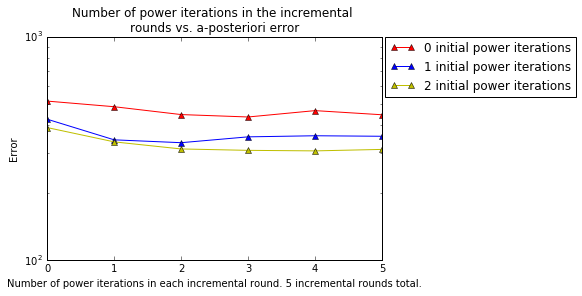

In [3710]:
pt.semilogy(it_ps, errs1, '-^', label="0 initial power iterations", color='r');
pt.semilogy(it_ps, errs2, '-^', label="1 initial power iterations", color='b')
pt.semilogy(it_ps, errs3, '-^', label="2 initial power iterations", color='y') ;pt.xlabel("Number of power iterations in each incremental round. 5 incremental rounds total."); pt.ylabel("Error")
pt.legend(loc=2, borderaxespad=0, bbox_to_anchor=(1.01, 1)); pt.title("Number of power iterations in the incremental \nrounds vs. a-posteriori error"); pt.show()

In [3711]:
it_ps = range(6, 12)
errs1 = [compute_error(it_k=1, it_p=1, method='modified_gram_schmidt', max_p_iter=it_p) for it_p in (it_ps)]
errs2 = [compute_error(it_k=1, it_p=2, method='modified_gram_schmidt', max_p_iter=it_p) for it_p in (it_ps)];
errs3 = [compute_error(it_k=1, it_p=3, method='modified_gram_schmidt', max_p_iter=it_p) for it_p in (it_ps)];

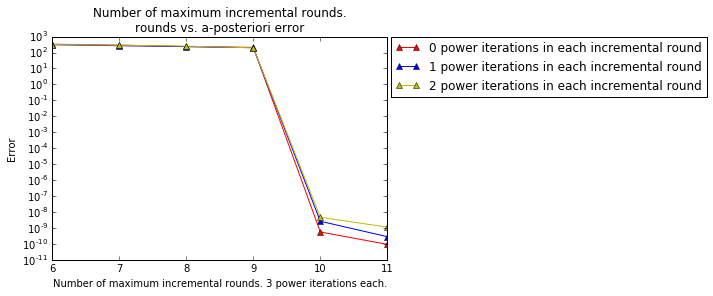

In [3712]:
pt.semilogy(it_ps, errs1, '-^', label="0 power iterations in each incremental round", color='r');
pt.semilogy(it_ps, errs2, '-^', label="1 power iterations in each incremental round", color='b')
pt.semilogy(it_ps, errs3, '-^', label="2 power iterations in each incremental round", color='y') ;pt.xlabel("Number of maximum incremental rounds. 3 power iterations each."); pt.ylabel("Error")
pt.legend(loc=2, borderaxespad=0, bbox_to_anchor=(1.01, 1)); pt.title("Number of maximum incremental rounds.\nrounds vs. a-posteriori error"); pt.show()